In [658]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [659]:
function simplex2D(elem_num, xp, yp)
    global ELEMENTS
    global NODE_COORD 

    trinodes = ELEMENTS[elem_num, :]; 
    x1 = NODE_COORD[trinodes[1],1];
    y1 = NODE_COORD[trinodes[1],2];
    x2 = NODE_COORD[trinodes[2],1];
    y2 = NODE_COORD[trinodes[2],2];
    x3 = NODE_COORD[trinodes[3],1];
    y3 = NODE_COORD[trinodes[3],2];

    σ0 = det([1. x1 y1; 1. x2 y2; 1. x3 y3]);
    σ1 = det([1. xp yp; 1. x2 y2; 1. x3 y3]);
    σ2 = det([1. x1 y1; 1. xp yp; 1. x3 y3]);
    σ3 = det([1. x1 y1; 1. x2 y2; 1. xp yp]);
    λ  = [σ1/σ0, σ2/σ0, σ3/σ0]
    return λ
end

simplex2D (generic function with 1 method)

In [762]:
const qx = [1/6, 2/3, 1/6]
const qy = [2/3, 1/6, 1/6]
const wg = [1/6, 1/6, 1/6]

function basis() # for integration points
    x1, x2, x3 = qx[1], qx[2], qx[3]
    y1, y2, y3 = qy[1], qy[2], qy[3]
    ϕ = zeros(3, 2, 3)
    ϕ[:,:,1] .= [ x1   (y1 - 1.0);   x2  (y2 - 1.0);   x3  (y3 - 1.0)]
    ϕ[:,:,2] .= [ x1    y1;          x2   y2;          x3   y3]
    ϕ[:,:,3] .= [(x1 - 1.0)    y1;  (x2 - 1.0)   y2;  (x3 - 1.0)   y3]
    return ϕ
end

function TandD(x1, y1, x2, y2, x3, y3)
    global LOCALEDGENODES
    J = [(x2 - x1) (x3 - x1); (y2 - y1) (y3 - y1)]
    ϕ = basis()
    T = spzeros(3, 3)
    D = ones(1, 3)
    
    for i=1:3
        for j=1:3
            for k=1:3
                T[i, j] += wg[k] / abs(det(J)) * dot(J * ϕ[k,:,i], J * ϕ[k,:,j])
            end
        end
        D[i] = sign(det(J))
    end

    return T, D
end

TandD (generic function with 1 method)

In [763]:
ε0 = 1.0 #8.854e-12
μ0 = 1.0 #4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
# Meshing
a = 1.0 # m
b = 1.0 # m
nothing

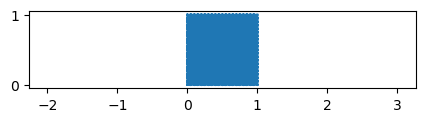

In [854]:
using PyPlot

LOCALEDGENODES = [1 2; 2 3; 3 1]
NUM_ELEMS = 2
ELEMENTS = [1 2 4; 1 3 4]
NUM_NODES = 4
NODE_COORD = [0.0 0.0; 1.0 0.0; 0.0 1.0; 1.0 1.0]
trimesh(a, b, 20, 20)
triedgemake()

figure(figsize=(5,1))
triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
axis("equal");

In [855]:
DOF_NONE = 0
DOF_PEC  = 1
function dof_type(a, b)
    global NUM_EDGES
    global EDGES
    global NODE_COORD
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
       node1 = EDGES[i_edge, 1]
       node2 = EDGES[i_edge, 2]
       if NODE_COORD[node1, 2] ≈ 0. && NODE_COORD[node2, 2] ≈ 0.
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 2] ≈ b  && NODE_COORD[node2, 2] ≈ b
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ 0. && NODE_COORD[node2, 1] ≈ 0.
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ a  && NODE_COORD[node2, 1] ≈ a
           dof_flag[i_edge] = DOF_PEC
       end
    end
    return dof_flag
end

dof_type (generic function with 1 method)

In [856]:
dof = collect(1:NUM_EDGES+NUM_ELEMS)
Γ = dof_type(a, b);
NUM_DOFS = NUM_EDGES;

In [857]:
using SparseArrays

T = spzeros(NUM_DOFS, NUM_DOFS) # 1/ε ∫( ∇Ni ⋅ ∇Nj )dΩ
D = spzeros(NUM_DOFS, NUM_ELEMS) #    ∫((∇⋅Ni) ⋅ Nk )dΩ

for ielem = 1:NUM_ELEMS # Assemble by elements
  trinodes = ELEMENTS[ielem, :]
  Te, De = TandD(NODE_COORD[trinodes[1],1], NODE_COORD[trinodes[1],2],
                 NODE_COORD[trinodes[2],1], NODE_COORD[trinodes[2],2],
                 NODE_COORD[trinodes[3],1], NODE_COORD[trinodes[3],2])
  droptol!(Te, 1e-15)
  
  for jedge = 1:3
    j1 = ELEMENTS[ielem, LOCALEDGENODES[jedge,1]] 
    j2 = ELEMENTS[ielem, LOCALEDGENODES[jedge,2]]
    je = NODE_EDGES[j1, j2]
    jd = sign(je)
    jj = dof[abs(je)]
    for kedge = 1:3
      k1 = ELEMENTS[ielem, LOCALEDGENODES[kedge,1]]
      k2 = ELEMENTS[ielem, LOCALEDGENODES[kedge,2]]
      ke = NODE_EDGES[k1, k2]
      kd = sign(ke)
      kk = dof[abs(ke)]
      T[jj, kk] = T[jj, kk] + jd * kd * Te[jedge, kedge]
    end
    D[jj, ielem] = D[jj, ielem] + jd * De[jedge]
  end
end

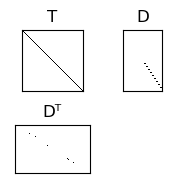

In [858]:
figure(figsize=(2, 2))
subplot(2, 2, 1); spy(T);  title("T"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(D);  title("D"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(D'); title("Dᵀ"); xticks([]); yticks([]);
tight_layout()

In [859]:
Z = spzeros(NUM_ELEMS, NUM_ELEMS)
droptol!(T, 1e-15)
A = [T  D
     D' Z]

2040×2040 SparseMatrixCSC{Float64, Int64} with 7640 stored entries:
⢿⣷⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠘⢻⣶⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠘⠿⣧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣧⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠉⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢷⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⢻⣶⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢿⣷⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣧⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣧⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢷⡄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢻⣶⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢻⣆⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣶⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣦⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣧⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢷⡄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢻⣄⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣶⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣦
⠛⢶⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈
⠀⠀⠈⠙⠷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠙⠷⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠷⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠷⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠳⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠷⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠳⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [860]:
# from darcy.py
sparse([
    0.3333         0    0.0000   -0.1667         0    1.0000         0
         0    0.3333   -0.0000         0   -0.1667         0    1.0000
    0.0000   -0.0000    0.3333   -0.0000    0.0000    1.0000   -1.0000
   -0.1667         0   -0.0000    0.3333         0    1.0000         0
         0   -0.1667    0.0000         0    0.3333         0    1.0000
    1.0000         0    1.0000    1.0000         0         0         0
         0    1.0000   -1.0000         0    1.0000         0         0]) \
[0., 0., 0., 0., 0., 4.9348022, 4.9348022]

7-element Vector{Float64}:
  2.4674011
  2.4674011
  0.0
  2.4674011
  2.4674011
 -0.41106902326
 -0.41106902326000005

In [861]:
function f(x, y) sin(2π * x) * sin(2π * y) end
function volumeforce(x1, y1, x2, y2, x3, y3)
    area = abs(det([1. x1 y1
                    1. x2 y2
                    1. x3 y3]))
    xc = (x1 + x2 + x3) / 3.0
    yc = (y1 + y2 + y3) / 3.0
    
    return - area *f(xc, yc)
end

volumeforce (generic function with 1 method)

In [862]:
rhs = zeros(NUM_EDGES + NUM_ELEMS)
for ielem=1:NUM_ELEMS
    trinodes = ELEMENTS[ielem, :]
    dof = NUM_EDGES + ielem 
    rhs[dof] = volumeforce(NODE_COORD[trinodes[1],1], NODE_COORD[trinodes[1],2],
                           NODE_COORD[trinodes[2],1], NODE_COORD[trinodes[2],2],
                           NODE_COORD[trinodes[3],1], NODE_COORD[trinodes[3],2])
end

u = A \ rhs
E = view(u, 1:NUM_EDGES)
V = view(u, NUM_EDGES+1:NUM_EDGES+NUM_ELEMS)
nothing
u

2040-element Vector{Float64}:
 -0.0012369909539845967
  0.0012369909539845967
  0.0024466664088864504
 -0.003602506744545633
  0.0046655169693770905
  0.0011692991154698509
 -0.005619953876971678
  0.006428219337683955
  0.0009831234457323887
 -0.007089139145411268
  0.007562185475118795
  0.0006993570912283677
 -0.00786514852323618
  ⋮
 -0.0010048536850492918
 -0.00020154302771373272
  0.0006214080523886894
  0.0013834445796455119
  0.0020099796635618073
  0.0024396982996811277
  0.00263056533960957
  0.0025639523704356075
  0.002246486866599026
  0.001709464051368493
  0.0010059523956035678
  0.0002061651589974325

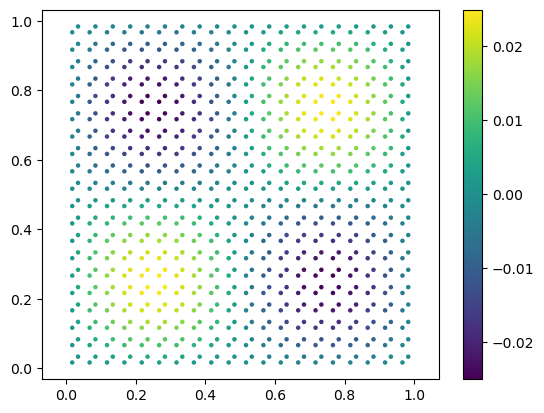

(-0.02500015235530623, 0.024971808756615203)

In [863]:
solution = zeros(NUM_ELEMS, 3)
for ielem=1:NUM_ELEMS
    trinodes = ELEMENTS[ielem, :]
    xc = (NODE_COORD[trinodes[1],1] +
          NODE_COORD[trinodes[2],1] +
          NODE_COORD[trinodes[3],1]) / 3.0
    yc = (NODE_COORD[trinodes[1],2] +
          NODE_COORD[trinodes[2],2] +
          NODE_COORD[trinodes[3],2]) / 3.0
    solution[ielem, 1] = xc
    solution[ielem, 2] = yc
    solution[ielem, 3] = u[NUM_EDGES + ielem]
end

scatter(solution[:, 1], solution[:, 2], c=solution[:, 3], s=5.0)
axis("equal")
colorbar()
extrema(solution[:,3])